# Final Project Code

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn as skl
from scipy.io import loadmat
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

C:\tools\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load the data
data = np.loadtxt("breast-cancer-wisconsin.data.csv", delimiter=",")

#change 2 to 0 and 4 to 1
for i in range(len(data)):
    if data[i,10] == 2:
        data[i,10] = 0
    elif data[i,10] == 4:
        data[i,10] = 1
        
X = data[:,1:10]
Y = data[:,10]

# PLS-DA

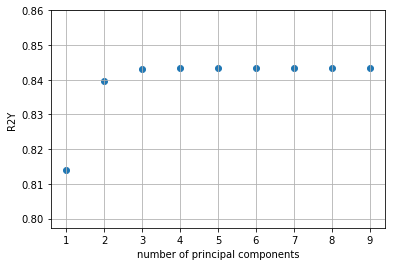

[ 0.81397888  0.83974134  0.84295668  0.84325165  0.84329905  0.84332356
  0.84332412  0.84332413  0.84332413]


In [3]:
#Perform PLS-DA
n = 10
R2Y = np.zeros(n-1)
for i in range(1,n):
    PLS = PLSRegression(n_components = i, max_iter = 1000)
    #now we can call functions on PLS such as "PLS.fit"

    xScores, yScores = PLS.fit_transform(scale(X), scale(Y)) # xSc is not the same as PLS.x_scores_

    R2Y[i-1] = PLS.score(scale(X), scale(Y))

    #Y_predict = PLS.predict(X)
    #R2Y[i-1] = 1 - (np.sum(Y_predict - Y48)**2) / np.sum(Y48)**2

plt.figure()
plt.scatter(np.arange(1,n), R2Y)
plt.xlabel("number of principal components")
plt.ylabel("R2Y")
plt.grid()
plt.show()
print(R2Y)

In [4]:
#Choose 2 components
PLS = PLSRegression(n_components = 2, max_iter = 1000)
xScores1, yScores = PLS.fit_transform(scale(X), scale(Y))
xloadings = PLS.x_loadings_
yloadings = PLS.y_loadings_

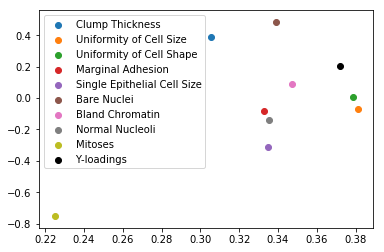

In [5]:
#Overlay X and y Loadings
labels = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']
for i in range(len(xloadings)):
    plt.scatter(xloadings[i,0], xloadings[i,1], label = labels[i] )

plt.scatter(yloadings[:,0], yloadings[:,1], c = 'k', label = 'Y-loadings')
plt.legend(loc = 2)
plt.show()

In [6]:
#Predict Y
#Y_predicted = PLS.predict(scale(X))

print(xloadings)

[[ 0.30539225  0.3881054 ]
 [ 0.38115606 -0.06826798]
 [ 0.37845571  0.00669318]
 [ 0.33289709 -0.08198907]
 [ 0.33477416 -0.31300279]
 [ 0.33910089  0.48546142]
 [ 0.34715878  0.08893164]
 [ 0.33532208 -0.14104308]
 [ 0.22530291 -0.75133983]]


In [7]:
yloadings


array([[ 0.37215109,  0.20265095]])

In [8]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

def find_plsda(num_components, X, Y):
    yplsda = np.zeros(len(Y))
    Xda = scale(X)
    Yda = scale(Y)
    kfs = KFold(n_splits=5)
    for train_index, test_index in kfs.split(X):
        X_train, X_test = Xda[train_index], Xda[test_index]
        Y_train, Y_test = Yda[train_index], Yda[test_index]
        PLS = PLSRegression(n_components = num_components, max_iter = 1000)
        xScores, yScores = PLS.fit_transform(X_train, Y_train);
        yplsda[test_index] = PLS.predict(X_test);
    return yplsda

In [9]:
#Create a cutoff for what is classified as 0 vs 1
from sklearn.metrics import confusion_matrix

yplsda_pred = np.zeros(len(Y))
j = -1
for i in find_plsda(2,X,Y):
    j = j +1
    if i>0:
        yplsda_pred[j] = 1
    else:
        yplsda_pred[j] = 0

confusions_matrix = confusion_matrix(Y, yplsda_pred)
print(confusions_matrix)

[[431  13]
 [  6 233]]


C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  


C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  


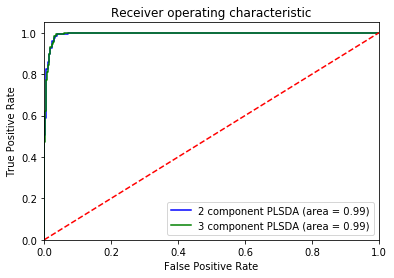

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
plt.figure()
a = find_plsda(2, X, Y)
logit_roc_auc = roc_auc_score(Y, a)
fpr, tpr, thresholds = roc_curve(Y, a)
plt.plot(fpr, tpr, c = 'b', label='2 component PLSDA (area = %0.2f)' % logit_roc_auc)

b = find_plsda(3, X, Y)
logit_roc_auc = roc_auc_score(Y, b)
fpr, tpr, thresholds = roc_curve(Y, b)
plt.plot(fpr, tpr, c = 'g', label='3 component PLSDA (area = %0.2f)' % logit_roc_auc)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.xlim(0,0.044)
plt.show()


C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  


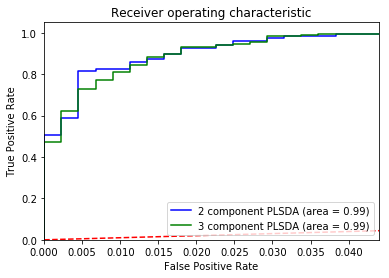

In [57]:
plt.figure()
a = find_plsda(2, X, Y)
logit_roc_auc2 = roc_auc_score(Y, a)
fpr, tpr, thresholds = roc_curve(Y, a)
plt.plot(fpr, tpr, c = 'b', label='2 component PLSDA (area = %0.2f)' % logit_roc_auc2)

b = find_plsda(3, X, Y)
logit_roc_auc3 = roc_auc_score(Y, b)
fpr, tpr, thresholds = roc_curve(Y, b)
plt.plot(fpr, tpr, c = 'g', label='3 component PLSDA (area = %0.2f)' % logit_roc_auc3)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.xlim(0,0.044)
plt.show()

## Logistic Regression

Perform Logistic Regression on the data

In [30]:
from sklearn.model_selection import KFold

def perform_logreg(Y):
    y_pred = np.zeros(len(Y))
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        logreg = LogisticRegression()
        logreg.fit(X_train, Y_train);
        y_pred[test_index] = logreg.predict(X_test)
    return y_pred, logreg.coef_, logreg.predict_proba(X)[:,1]

In [31]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
lr = perform_logreg(Y)
y_pred, proba = lr[0], lr[2]
confusion_matrix = confusion_matrix(Y, y_pred)
print(confusion_matrix)

[[433  11]
 [ 15 224]]


The result from the confusion matrix is telling us that we have 433+224 correct predictions and 15+11 incorrect predictions.

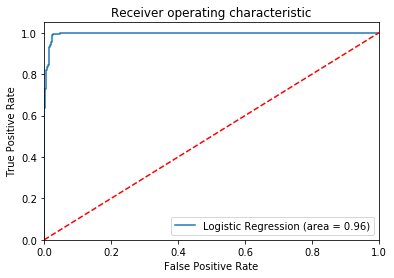

In [32]:
#Receiver operating characteristic: ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y, y_pred)
fpr, tpr, thresholds = roc_curve(Y, proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [33]:
lr[1]  #the order of the weights are the same order as the loadings plot order..right?

array([[ 0.2629702 ,  0.07038626,  0.29805539,  0.16949667,  0.0030046 ,
         0.34251731,  0.1049674 ,  0.17507735,  0.2091854 ]])

##Bootstrap the coefficients

In [39]:
import sklearn

coefs = np.zeros((1000,9))
for bootstrapi in range(1000):
    X_index = range(X.shape[0])
    resamp = sklearn.utils.resample(X_index)
    Ycurr = Y[resamp]
    Xcurr = X[resamp]
    coefs[bootstrapi,:] = perform_logreg(Ycurr)[1]

def generate_array(coefs, i, label):
    vals = coefs[:,i]
    return vals, label[i]

In [40]:
##Overlay ROCs

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  


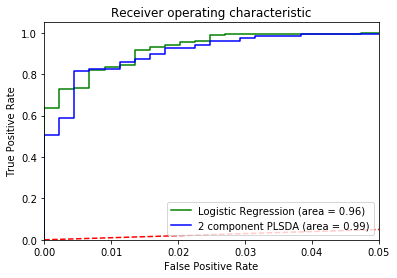

[-0.51861514 -0.68875326 -0.6101607  -0.53156814 -0.68875326  0.07059535
 -0.26991313 -0.89727989 -0.52159992 -0.39406177]
[ 0.05871279  0.02573901  0.03322377  0.04278947  0.02573901  0.26825522
  0.12512781  0.0138629   0.05015221  0.10793866]


In [56]:
logit_roc_auc = roc_auc_score(Y, y_pred)
fpr, tpr, thresholds = roc_curve(Y, lr[2])
plt.figure()
plt.plot(fpr, tpr, c = 'g', label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

a = find_plsda(2, X, Y)
logit_roc_aucp = roc_auc_score(Y, a)
fpr, tpr, thresholds = roc_curve(Y, a)
plt.plot(fpr, tpr, c = 'b', label='2 component PLSDA (area = %0.2f)' % logit_roc_aucp)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.xlim(0,0.044)
plt.xlim(0,0.05)
#plt.ylim(0.95,1.01)
plt.show()


print(a[600:610])
print(lr[2][600:610])

Histograms showing our bootsrapped results

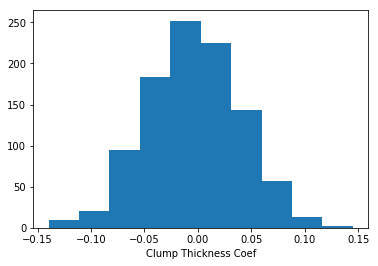

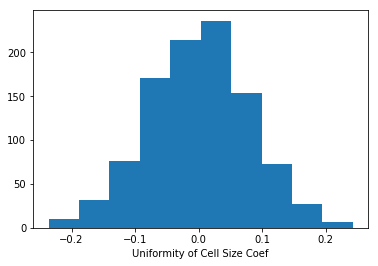

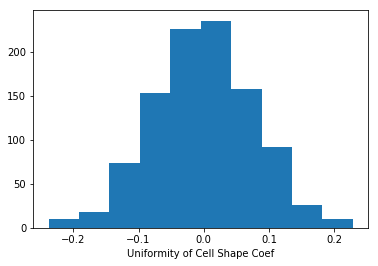

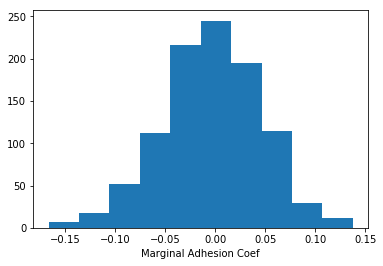

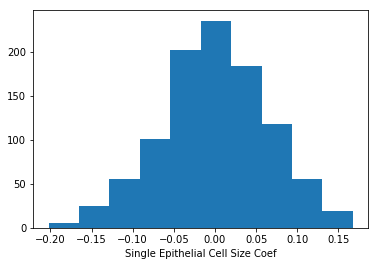

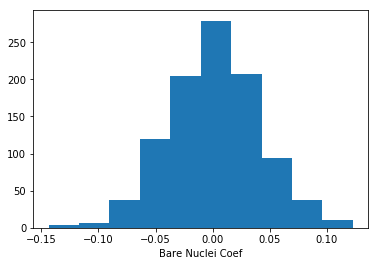

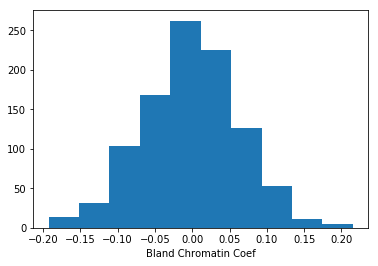

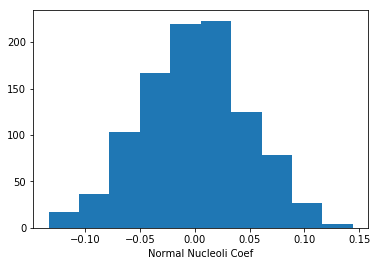

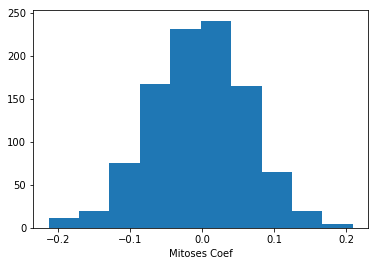

In [44]:
labelz = ['Clump Thickness Coef', 'Uniformity of Cell Size Coef', 'Uniformity of Cell Shape Coef','Marginal Adhesion Coef','Single Epithelial Cell Size Coef','Bare Nuclei Coef','Bland Chromatin Coef','Normal Nucleoli Coef','Mitoses Coef']

for i in range(9):
    a1 = generate_array(coefs,i, labelz)
    plt.figure()
    plt.hist(a1[0]);
    plt.xlabel(a1[1])

#Just for Analysis

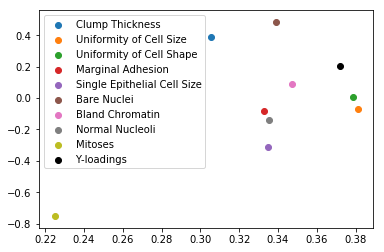

In [43]:
labels = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']
for i in range(len(xloadings)):
    plt.scatter(xloadings[i,0], xloadings[i,1], label = labels[i] )

plt.scatter(yloadings[:,0], yloadings[:,1], c = 'k', label = 'Y-loadings')
plt.legend(loc = 2)
plt.show()